In [79]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Importar data
filename = 'data/garments_worker_productivity.csv'
data = pd.read_csv(filename)

In [3]:
# Obtener el tamaño del conjunto de datos
print(data.shape)

(1197, 15)


In [4]:
# Obtener el detalle de la información
# Se observa que la columna wip presenta valores nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [22]:
data.describe()

,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month,tiene_incentivo,trabajador_inactivo,tiempo_parado,parada_produccion,diferencia_productividad,problema_productividad
count,1197.000000,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,13.533835,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091,1.724311,0.495405,0.015038,0.015038,0.015038,0.005459,0.269006
std,8.623967,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488,0.744558,0.500188,0.121753,0.121753,0.121753,0.160082,0.443628
min,1.000000,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,1.000000,0.000000,0.000000,0.000000,0.000000,-0.561958,0.000000
25%,6.000000,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307,1.000000,0.000000,0.000000,0.000000,0.000000,-0.009556,0.000000
50%,12.000000,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333,2.000000,0.000000,0.000000,0.000000,0.000000,0.000505,0.000000
75%,21.000000,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253,2.000000,1.000000,0.000000,0.000000,0.000000,0.099111,1.000000
max,31.000000,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437,3.000000,1.000000,1.000000,1.000000,1.000000,0.644375,1.000000


In [5]:
# Obtener los valores únicos de cada atributo
data.nunique()

date                      59
quarter                    5
department                 3
day                        6
team                      12
targeted_productivity      9
smv                       70
wip                      548
over_time                143
incentive                 48
idle_time                 12
idle_men                  10
no_of_style_change         3
no_of_workers             61
actual_productivity      879
dtype: int64

In [6]:
# Porcentaje de valores nulos
# La única variable que presenta valores nulos es wip (trabajo en proceso)

pct_nulos = (data.isna().sum() /len(data)*100).to_frame().reset_index().rename(columns={'index':'atributo', 0:'pct_nulos'})
pct_nulos[pct_nulos['pct_nulos'] > 0].reset_index(drop=True)

,atributo,pct_nulos
0,wip,42.272348


In [7]:
# Corregir el formato de la columna fecha
data['day'] = data['date'].apply(lambda x: x[:x.find('/')])
data['day'] = data['day'].apply(lambda x: '0' + x if len(x) == 1 else x)
data['month'] = data['date'].apply(lambda x: x[:-4][x.find('/') + 1:-1])
data['month'] = data['month'].apply(lambda x: '0' + x if len(x) == 1 else x)
data['year'] = data['date'].apply(lambda x: x[-4:])

data['date'] = data['day'] + '/' + data['month'] + '/' + data['year']
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')

data['day'] = data['date'].apply(lambda x: x.day)
data['month'] = data['date'].apply(lambda x: x.month)
data['year'] = data['date'].apply(lambda x: x.year)

In [8]:
# Los datos que se analizarán corresponden a los meses de enero, febrero y marzo del 2015
print('Fecha mínima: {}'.format(data['date'].min()))
print('Fecha máxima: {}'.format(data['date'].max()))

Fecha mínima: 2015-01-01 00:00:00
Fecha máxima: 2015-03-11 00:00:00


In [9]:
# Corregir los datos de la columna departament
departamento_valores = {
    'sweing': 'Costura'
    , 'finishing ': 'Acabado'
    , 'finishing':'Acabado'
}
data['department'] = data['department'].map(departamento_valores)

In [10]:
# Estadística descriptiva de los datos
data.drop(columns=['day', 'month','year']).describe().T.reset_index().round(2)

,index,count,mean,std,min,25%,50%,75%,max
0,team,1197.0,6.43,3.46,1.00,3.00,6.00,9.00,12.00
1,targeted_productivity,1197.0,0.73,0.10,0.07,0.70,0.75,0.80,0.80
2,smv,1197.0,15.06,10.94,2.90,3.94,15.26,24.26,54.56
3,wip,691.0,1190.47,1837.46,7.00,774.50,1039.00,1252.50,23122.00
4,over_time,1197.0,4567.46,3348.82,0.00,1440.00,3960.00,6960.00,25920.00
5,incentive,1197.0,38.21,160.18,0.00,0.00,0.00,50.00,3600.00
6,idle_time,1197.0,0.73,12.71,0.00,0.00,0.00,0.00,300.00
7,idle_men,1197.0,0.37,3.27,0.00,0.00,0.00,0.00,45.00
8,no_of_style_change,1197.0,0.15,0.43,0.00,0.00,0.00,0.00,2.00
9,no_of_workers,1197.0,34.61,22.20,2.00,9.00,34.00,57.00,89.00


In [11]:
# Agregar si el grupo de trabajo tuvo un incentivo (cantidad mayor a 0) o no
data['tiene_incentivo'] = data['incentive'].apply(lambda x: 1 if x>0 else 0)

In [12]:
# Eliminar la columna año ya que tiene un único valor
data = data.drop(columns=['year'])

In [13]:
# Agregar si hubo un tiempo o trabajadores inactivos en el turno
data['trabajador_inactivo'] = data['idle_men'].apply(lambda x: 1 if x>0 else 0)
data['tiempo_parado'] = data['idle_time'].apply(lambda x: 1 if x>0 else 0)

In [14]:
# Agregar si hubo parada en la producción
data['parada_produccion'] = data['trabajador_inactivo'] + data['tiempo_parado']
data['parada_produccion'] = data['parada_produccion'].apply(lambda x: 1 if x > 0 else 0)

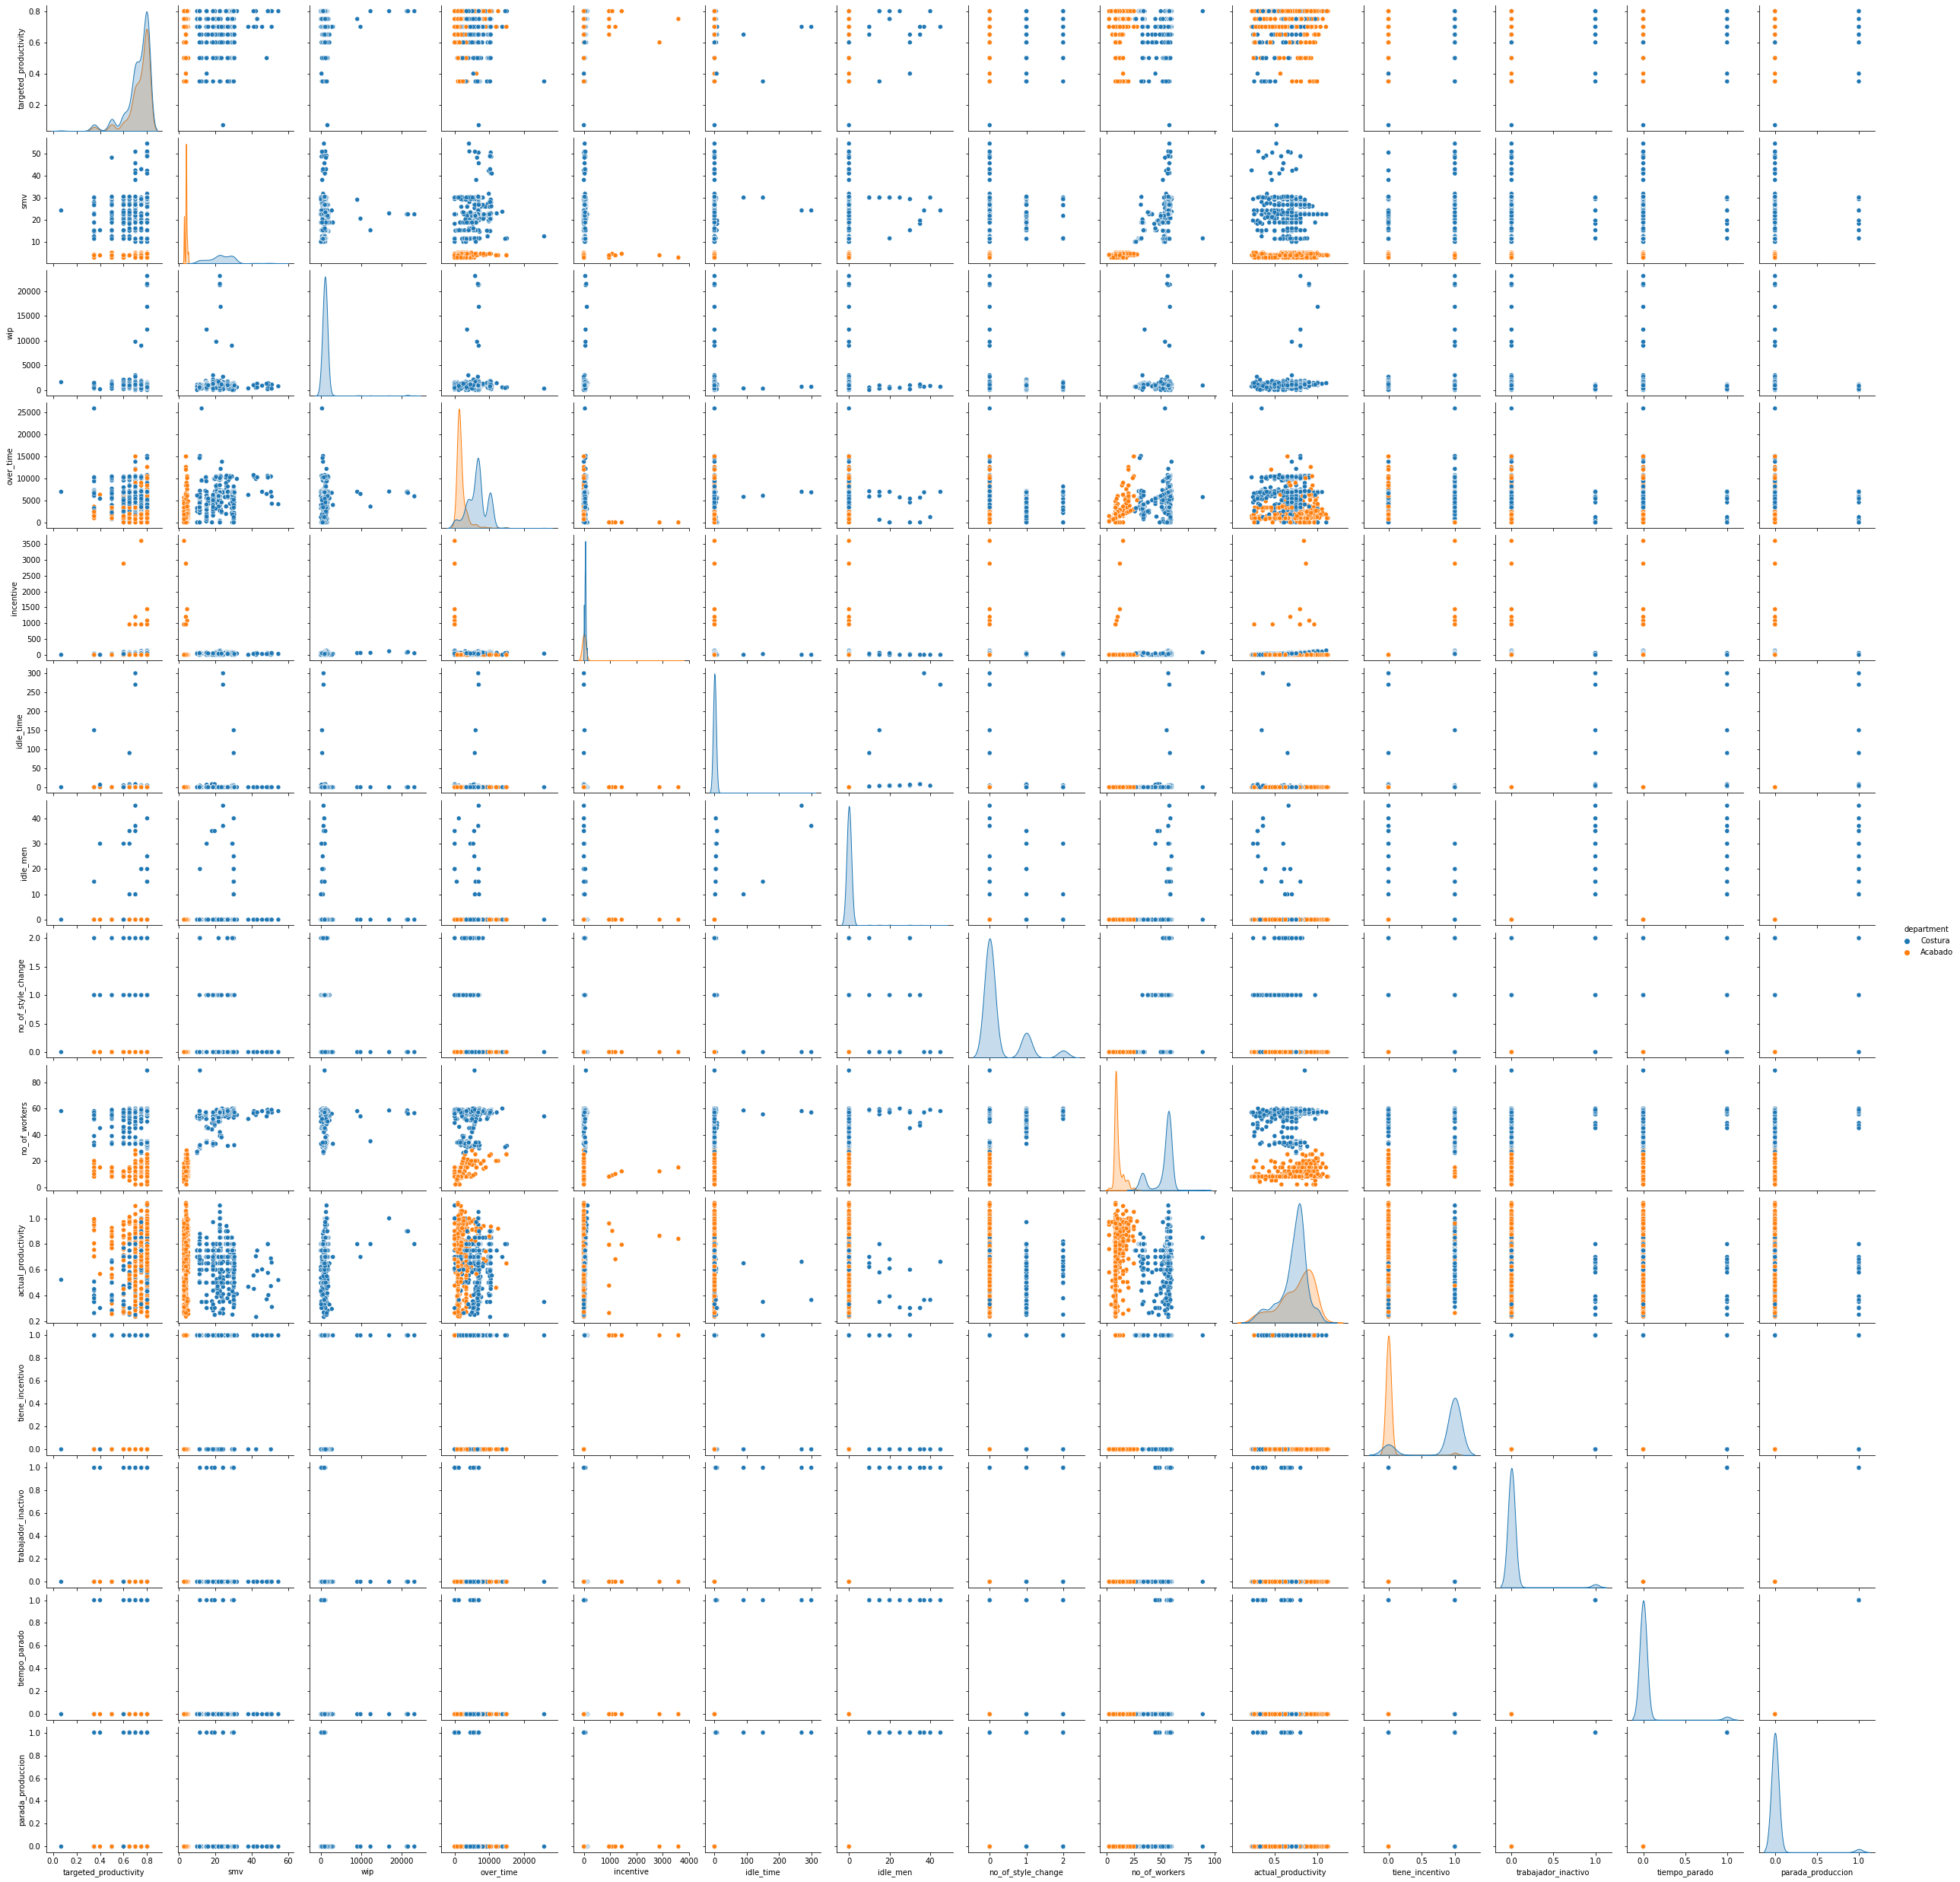

In [15]:
col_interes = data[['targeted_productivity',
       'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers', 'actual_productivity',
        'tiene_incentivo', 'trabajador_inactivo', 'tiempo_parado', 'parada_produccion','department']]

sns.pairplot(col_interes, hue='department');

In [16]:
# Tipo de letra a utilizar en los gráficos
plt.rcParams.update({'font.sans-serif':'Times New Roman'})

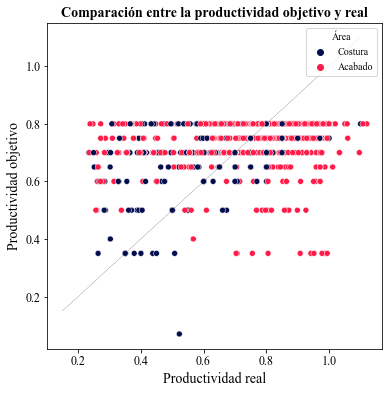

In [17]:
# Existe una diferencia entre la productividad real y la objetivo

palette = ['#030E4F', '#FF1C49']
diagonal_line = np.arange(0.15,1.15,0.05)

plt.figure(figsize=(6, 6))

sns.lineplot(x=diagonal_line, y=diagonal_line, color='#000000', ls='--', linewidth=0.25)
sns.scatterplot(data=data
                , x='actual_productivity'
                , y='targeted_productivity'
                , hue='department'
                , s=35
                , palette=palette)

plt.title('Comparación entre la productividad objetivo y real'
          , fontsize=14
          , weight = 'bold')
plt.ylabel('Productividad objetivo'
           , fontsize=14)
plt.xlabel('Productividad real'
           , fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', title='Área')

plt.show()

In [18]:
# Calcular la diferencia entre la productividad real y objetivo. 
# Un número negativo indica que la productividad real estuvo por debajo de la objetivo
data['diferencia_productividad'] = data['actual_productivity'] - data['targeted_productivity']
data['problema_productividad'] = data['diferencia_productividad'].apply(lambda x: 1 if x<0 else 0)

In [19]:
print('El porcentaje de instancias con problemas de productividad fue de {}%'.format((data[data['problema_productividad'] == 1].shape[0] / data.shape[0]) * 100))

El porcentaje de instancias con problemas de productividad fue de 26.900584795321635%


In [20]:
# Para las instancias que presentaron problemas de productividad (productividad real inferior a la objetivo) se encuentra que
# en promedio, el departamento de acabado presentó una productividad real inferior en 0.18 a la objetivo.
# Para el departamento de costura, este número fue de 0.17.

print(data[data['problema_productividad'] == 1].groupby(['department'])['diferencia_productividad'].describe())
print('\n')
print(data[data['problema_productividad'] == 1]['diferencia_productividad'].describe())

            count      mean       std       min       25%       50%       75%  \
department                                                                      
Acabado     204.0 -0.189219  0.135068 -0.561958 -0.265903 -0.154419 -0.092469   
Costura     118.0 -0.175192  0.134791 -0.492499 -0.277789 -0.138323 -0.074425   

                 max  
department            
Acabado    -0.003693  
Costura    -0.000001  


count    322.000000
mean      -0.184078
std        0.134927
min       -0.561958
25%       -0.272412
50%       -0.146795
75%       -0.081760
max       -0.000001
Name: diferencia_productividad, dtype: float64


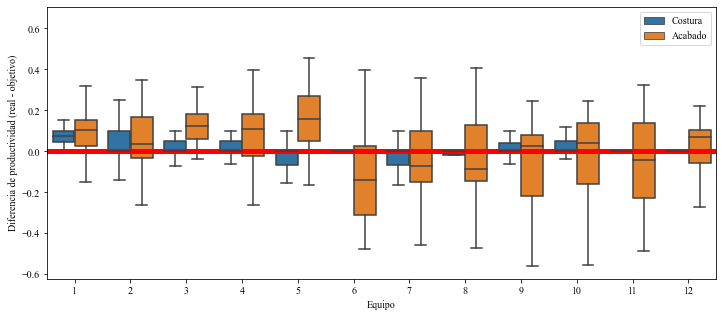

In [24]:
# La productividad de los equipos 1, 2, 3 y 4 presentan menores casos de incumplimiento de productividad en relación 
# a los otros equipos

plt.figure(figsize=(12, 5))
sns.boxplot(data=data, y='diferencia_productividad', x='team', hue='department', fliersize=0)
plt.axhline(y=0, color='r', linestyle='-', linewidth= 5)
plt.xlabel('Equipo')
plt.ylabel('Diferencia de productividad (real - objetivo)')
plt.legend(loc='upper right')
plt.show()

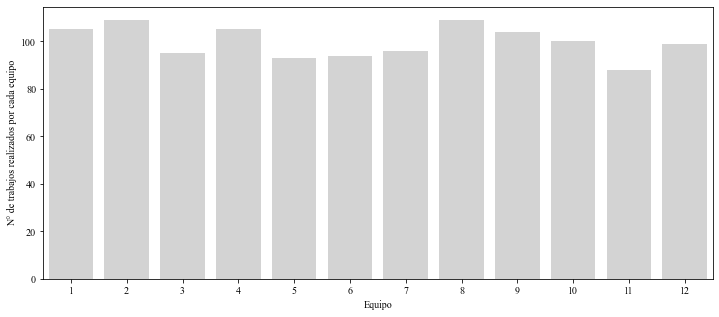

In [68]:
# N° de trabajos realizados por cada equipo

casos_equipo = data.groupby(['team'], as_index=False)['date'].count()

plt.figure(figsize=(12, 5))
sns.barplot(data=casos_equipo, y='date', x='team', color='#d3d3d3')
plt.ylabel('N° de trabajos realizados por cada equipo')
plt.xlabel('Equipo')
plt.show()

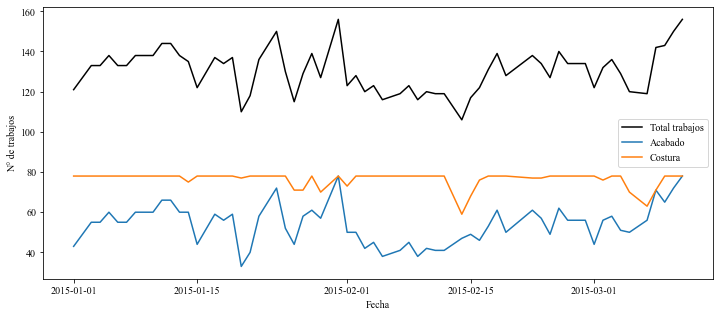

In [70]:
# Los trabajos de costura se mantuvieron casi constantes durante el periodo analizado mientras que los de acabado tuvieron 
# fluctuaciones más notorias

trabajos_fecha = data.groupby(['date', 'department'], as_index=False)['team'].sum().rename(columns={'team':'trabajos'})
trabajos_fecha = trabajos_fecha.pivot(index=['date'], columns=['department'], values='trabajos').reset_index()
trabajos_fecha['total'] = trabajos_fecha['Acabado'] + trabajos_fecha['Costura']

plt.figure(figsize=(12, 5))
sns.lineplot(data=trabajos_fecha, x='date', y='total', label='Total trabajos', color='#000000')
sns.lineplot(data=trabajos_fecha, x='date', y='Acabado', label='Acabado')
sns.lineplot(data=trabajos_fecha, x='date', y='Costura', label='Costura')
plt.ylabel('N° de trabajos')
plt.xlabel('Fecha')
plt.show()

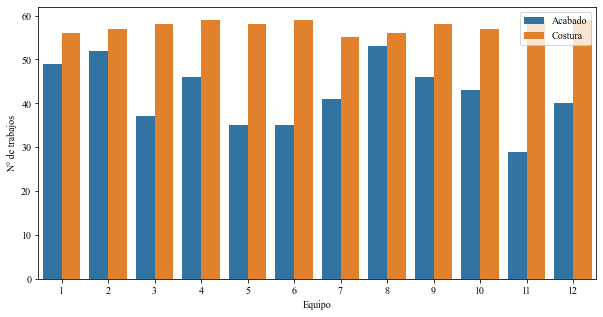

In [73]:
# Todos los equipos realizan trabajos de costura o acabado.
# Se observa que los trabajos de costura se realizan en mayor medida que los de acabado

plt.figure(figsize=(10, 5))

trabajo_por_equipo_departamento = data.groupby(['team', 'department'], as_index=False)['targeted_productivity'].count()
sns.barplot(data=trabajo_por_equipo_departamento, y='targeted_productivity', x='team', hue='department')
plt.ylabel('N° de trabajos')
plt.xlabel('Equipo')
plt.legend(loc='upper right')
plt.show()

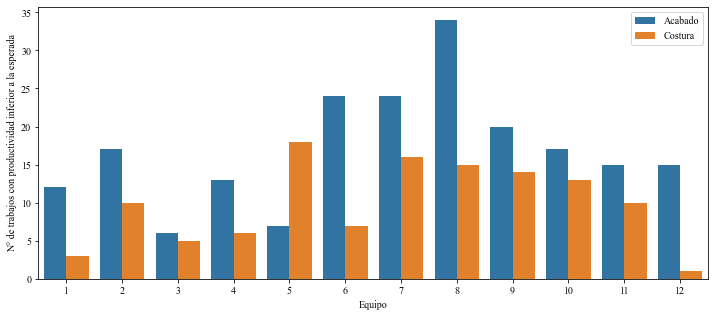

In [62]:
# Número de casos en los que que los equipos obtuvieron una productividad inferior a la esperada

productividad_equipo = data.groupby(['team','department'], as_index=False)['problema_productividad'].sum()

plt.figure(figsize=(12, 5))
sns.barplot(data=productividad_equipo, y='problema_productividad', x='team', hue='department')
plt.ylabel('N° de trabajos con productividad inferior a la esperada')
plt.xlabel('Equipo')
plt.legend(loc='upper right')
plt.show()

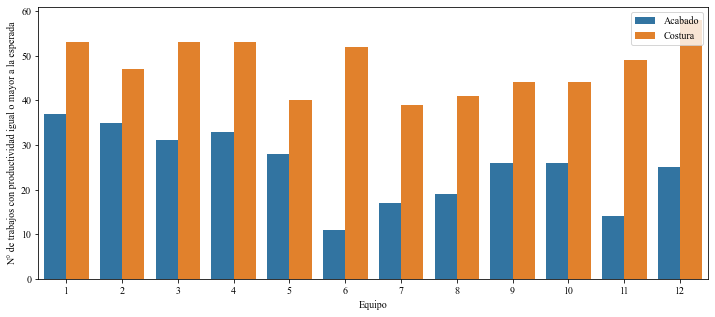

In [63]:
# Número de casos en los que que los equipos obtuvieron una productividad igual o mayor a la esperada

productividad_equipo = data[data['problema_productividad']==0].groupby(['team','department'], as_index=False).count()

plt.figure(figsize=(12, 5))
sns.barplot(data=productividad_equipo, y='problema_productividad', x='team', hue='department')
plt.ylabel('N° de trabajos con productividad igual o mayor a la esperada')
plt.xlabel('Equipo')
plt.legend(loc='upper right')
plt.show()

In [64]:
# La desviación estándar en las diferencias de productividad son menores para el área de costura que varían entre
# 0.01 y 0.14. Esta variación de la desviación estándar para acabado se encuentra entre 0.13 y 0.22

data.groupby(['department','team'])['diferencia_productividad'].describe()

count      mean       std       min       25%       50%  \
department team                                                            
Acabado    1      49.0  0.077803  0.131260 -0.245404  0.028150  0.103667   
           2      52.0  0.027245  0.183248 -0.552684 -0.032584  0.036879   
           3      37.0  0.106787  0.149736 -0.307500  0.060370  0.121704   
           4      46.0  0.102165  0.224219 -0.462958 -0.024589  0.108824   
           5      35.0  0.131600  0.200059 -0.369886  0.050537  0.159564   
           6      35.0 -0.094932  0.264885 -0.478125 -0.310972 -0.139792   
           7      41.0 -0.044643  0.212706 -0.457639 -0.151894 -0.073333   
           8      53.0 -0.020551  0.227392 -0.470455 -0.146402 -0.088021   
           9      46.0 -0.051560  0.193712 -0.561958 -0.216955  0.026868   
           10     43.0 -0.030071  0.208211 -0.553750 -0.160675  0.040533   
           11     29.0 -0.042382  0.222569 -0.486147 -0.229231 -0.041771   
           12     40.0  0.013583  0.155687 -0.528000 -0.055955  0.069091   
Costura    1      56.0  0.071400  0.112250 -0.396758  0.044701  0.075336   
           2      57.0  0.034324  0.137133 -0.488793  0.000070  0.000594   
           3      58.0  0.033060  0.087881 -0.263098  0.000274  0.000557   
           4      59.0  0.013628  0.085636 -0.326865  0.000232  0.000594   
           5      58.0 -0.040410  0.120849 -0.492499 -0.068883  0.000081   
           6      59.0 -0.016969  0.072890 -0.417854  0.000188  0.000359   
           7      55.0 -0.047474  0.147975 -0.433946 -0.067865  0.000241   
           8      56.0 -0.046940  0.127388 -0.398601 -0.019515  0.000313   
           9      58.0 -0.001624  0.087432 -0.302115  0.000035  0.000396   
           10     57.0 -0.010234  0.140959 -0.450583  0.000000  0.000422   
           11     59.0 -0.011971  0.072845 -0.387880  0.000035  0.000230   
           12     59.0 -0.001133  0.019235 -0.137744  0.000253  0.000402   

                      75%       max  
department team                      
Acabado    1     0.155152  0.320437  
           2     0.166914  0.350625  
           3     0.180340  0.372100  
           4     0.183985  0.638636  
           5     0.269267  0.455750  
           6     0.024681  0.627556  
           7     0.099188  0.357639  
           8     0.130417  0.644375  
           9     0.078314  0.244271  
           10    0.136687  0.247792  
           11    0.139514  0.321867  
           12    0.103889  0.221867  
Costura    1     0.100710  0.300484  
           2     0.100478  0.250281  
           3     0.050473  0.250230  
           4     0.050313  0.150556  
           5     0.000603  0.200534  
           6     0.000651  0.087995  
           7     0.000786  0.452845  
           8     0.000632  0.140725  
           9     0.042754  0.220817  
           10    0.050532  0.199995  
           11    0.000511  0.173245  
           12    0.000402  0.050521

In [65]:
# Todas las paradas ocurridas en la planta ocurrieron en el área de costura

data.groupby(['department'], as_index=False)[['trabajador_inactivo', 'tiempo_parado']].sum()

,department,trabajador_inactivo,tiempo_parado
0,Acabado,0,0
1,Costura,18,18


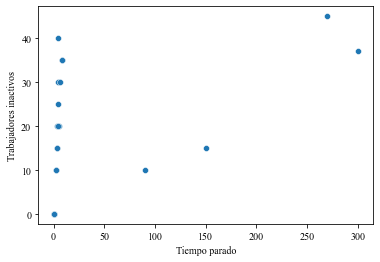

In [66]:
sns.scatterplot(data=data, x='idle_time', y='idle_men')
plt.xlabel('Tiempo parado')
plt.ylabel('Trabajadores inactivos')

plt.show()

In [67]:
# En general, para los equipos, el máximo número de trabajadores es de 60
data.groupby(['team'])['no_of_workers'].describe()

,count,mean,std,min,25%,50%,75%,max
team,,,,,,,,
1,105.0,35.042857,24.073517,2.0,8.0,56.5,58.00,59.0
2,109.0,34.623853,22.505365,8.0,10.0,45.0,57.00,59.0
3,95.0,39.521053,22.101063,7.0,12.0,56.0,57.00,60.0
4,105.0,38.200000,22.239799,8.0,15.0,56.0,58.00,60.0
5,93.0,39.381720,23.639319,2.0,12.0,58.0,58.00,60.0
6,94.0,25.170213,14.313043,5.0,8.0,31.5,33.00,89.0
7,96.0,37.098958,23.730906,8.0,8.0,56.0,58.00,60.0
8,109.0,33.490826,24.016389,4.0,8.0,52.0,57.00,60.0
9,104.0,35.211538,23.737817,2.0,8.0,52.0,58.00,59.0


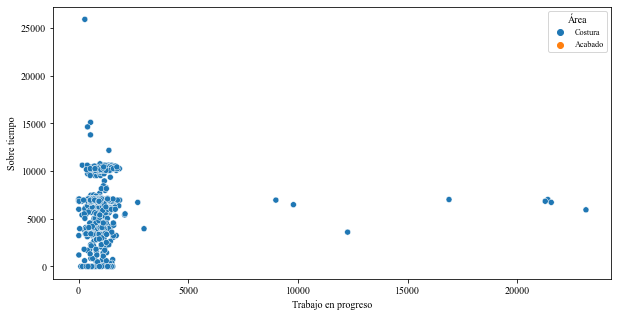

In [71]:
# No se oserva una relación clara entre el sobretiempo y el trabajo en proceso

plt.figure(figsize=(10, 5))
#sns.scatterplot(data=data[data['problema_productividad']==1], x='wip', y='over_time', hue='department')
sns.scatterplot(data=data, x='wip', y='over_time', hue='department')
plt.ylabel('Sobre tiempo')
plt.xlabel('Trabajo en progreso')
plt.legend(loc='upper right',title='Área', fontsize='small')
plt.show()

In [93]:
data.head(1)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,...,no_of_style_change,no_of_workers,actual_productivity,month,tiene_incentivo,trabajador_inactivo,tiempo_parado,parada_produccion,diferencia_productividad,problema_productividad
0,2015-01-01,Quarter1,Costura,1,8,0.8,26.16,1108.0,7080,98,...,0,59.0,0.940725,1,1,0,0,0,0.140725,0


In [104]:
df_incentivo = data.copy()
df_incentivo['incentivo_por_trabajador'] = df_incentivo['incentive'] / df_incentivo['no_of_workers']
df_incentivo['sobretiempo_por_trabajador'] = df_incentivo['over_time'] / df_incentivo['no_of_workers']

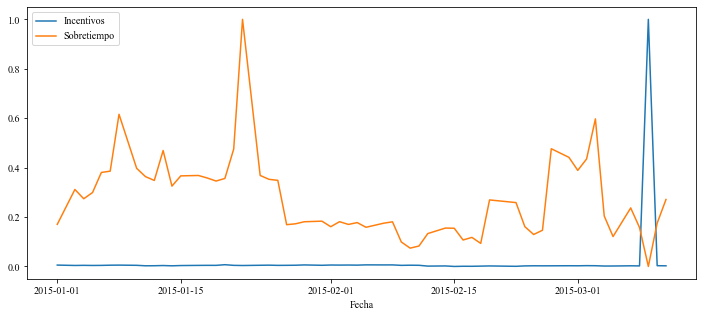

In [105]:
df_incentivo = df_incentivo.groupby(['date'], as_index=False)[['incentivo_por_trabajador','sobretiempo_por_trabajador']].mean()
scaler = MinMaxScaler()
df_incentivo[['incentivo_por_trabajador','sobretiempo_por_trabajador']] = scaler.fit_transform(df_incentivo[['incentivo_por_trabajador','sobretiempo_por_trabajador']])

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_incentivo, x='date', y='incentivo_por_trabajador', label='Incentivos')
sns.lineplot(data=df_incentivo, x='date', y='sobretiempo_por_trabajador', label='Sobretiempo')

plt.ylabel('')
plt.xlabel('Fecha')
plt.show()

<AxesSubplot:xlabel='incentivo_por_trabajador', ylabel='sobretiempo_por_trabajador'>

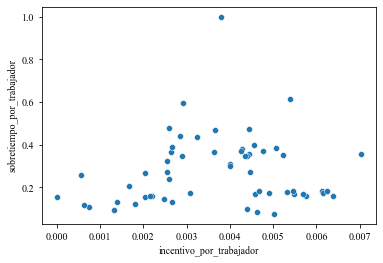

In [109]:
sns.scatterplot(data=df_incentivo[df_incentivo['incentivo_por_trabajador'] < 1], x='incentivo_por_trabajador', y='sobretiempo_por_trabajador')

In [89]:
# El atributo wip (trabajo en proceso) presenta valores nulos solo en el área de acabado
data[data['wip'].isnull()]['department'].unique()

array(['Acabado'], dtype=object)

In [110]:
data[data['department']=='Acabado']['wip'].describe()

count    506.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: wip, dtype: float64

In [111]:
# Los valores nulos de las instancias que corresponden al área de acabado serán llenadas con 0.
# Se escogió este valor porque lo más común en una fábrica de producción es que las piezas en proceso se generen en el área
# de costura. Aquellas piezas que llegan al área de acabado es porque están completas

data.loc[data['department']=='Acabado', 'wip'] = 0

In [112]:
# Luego de la corrección de valores nulos, la estadística descriptiva para el atributo wip es lo siguiente

data[~data['wip'].isnull()].groupby(['department', 'team'])['wip'].describe()

count         mean          std    min      25%     50%  \
department team                                                            
Acabado    1      49.0     0.000000     0.000000    0.0     0.00     0.0   
           2      52.0     0.000000     0.000000    0.0     0.00     0.0   
           3      37.0     0.000000     0.000000    0.0     0.00     0.0   
           4      46.0     0.000000     0.000000    0.0     0.00     0.0   
           5      35.0     0.000000     0.000000    0.0     0.00     0.0   
           6      35.0     0.000000     0.000000    0.0     0.00     0.0   
           7      41.0     0.000000     0.000000    0.0     0.00     0.0   
           8      53.0     0.000000     0.000000    0.0     0.00     0.0   
           9      46.0     0.000000     0.000000    0.0     0.00     0.0   
           10     43.0     0.000000     0.000000    0.0     0.00     0.0   
           11     29.0     0.000000     0.000000    0.0     0.00     0.0   
           12     40.0     0.000000     0.000000    0.0     0.00     0.0   
Costura    1      56.0  1609.196429  2105.399150  171.0  1185.00  1418.0   
           2      57.0  1326.280702  2737.032568   12.0   733.00   928.0   
           3      58.0  1409.293103  2667.081452   11.0   948.75  1129.0   
           4      59.0  1218.677966  2912.876872  287.0   702.00   864.0   
           5      58.0   773.741379   341.399368   15.0   541.75   699.0   
           6      59.0   936.559322   371.791853   52.0   772.50   913.0   
           7      55.0   999.509091   430.333414   29.0   761.50   970.0   
           8      56.0   984.375000   362.145102    7.0   863.50  1074.0   
           9      58.0  1283.724138  1088.338566   14.0  1068.25  1149.5   
           10     57.0  1528.333333  2717.815564   10.0  1082.00  1188.0   
           11     59.0   968.135593  1232.414402   13.0   564.00   749.0   
           12     59.0  1259.915254  1470.495475  470.0   976.50  1069.0   

                     75%      max  
department team                    
Acabado    1        0.00      0.0  
           2        0.00      0.0  
           3        0.00      0.0  
           4        0.00      0.0  
           5        0.00      0.0  
           6        0.00      0.0  
           7        0.00      0.0  
           8        0.00      0.0  
           9        0.00      0.0  
           10       0.00      0.0  
           11       0.00      0.0  
           12       0.00      0.0  
Costura    1     1537.00  16882.0  
           2     1396.00  21385.0  
           3     1256.75  21266.0  
           4      986.50  23122.0  
           5     1011.50   1480.0  
           6     1069.50   2984.0  
           7     1155.50   2698.0  
           8     1209.50   1557.0  
           9     1281.00   8992.0  
           10    1390.00  21540.0  
           11    1039.00   9792.0  
           12    1176.50  12261.0

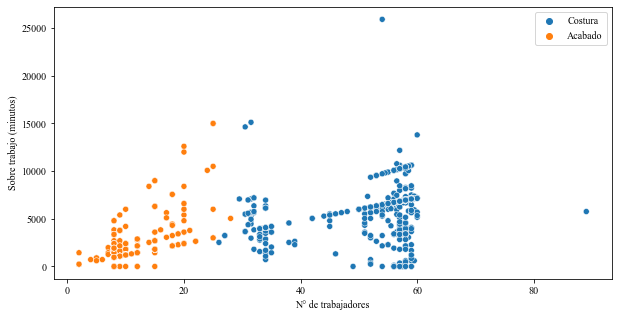

In [115]:
plt.figure(figsize=(10, 5))

sns.scatterplot(data=data, x='no_of_workers', y='over_time', hue='department')
plt.ylabel('Sobre trabajo (minutos)')
plt.xlabel('N° de trabajadores')
plt.legend(loc='upper right')
plt.show()

0.0


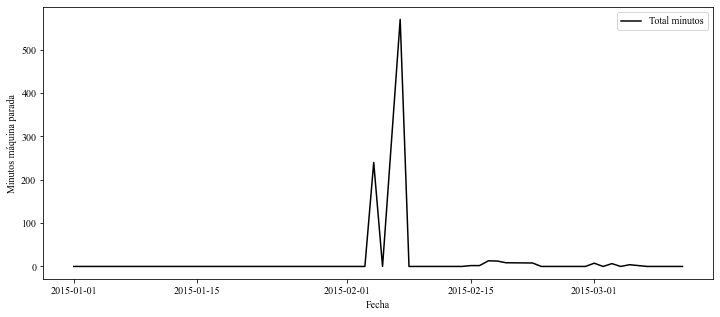

In [125]:
# Los minutos de paro de las máquinas se produjeron en el área de costura y alcanzaron picos entre el 1 y 15 de febrero

paradas_fecha = data.groupby(['date', 'department'], as_index=False)['idle_time'].sum()
paradas_fecha = paradas_fecha.pivot(index=['date'], columns=['department'], values='idle_time').reset_index()
paradas_fecha['total'] = paradas_fecha['Acabado'] + paradas_fecha['Costura']
print(paradas_fecha['Acabado'].sum())

plt.figure(figsize=(12, 5))
sns.lineplot(data=paradas_fecha, x='date', y='total', label='Total minutos', color='#000000')
plt.ylabel('Minutos máquina parada')
plt.xlabel('Fecha')
plt.show()

0


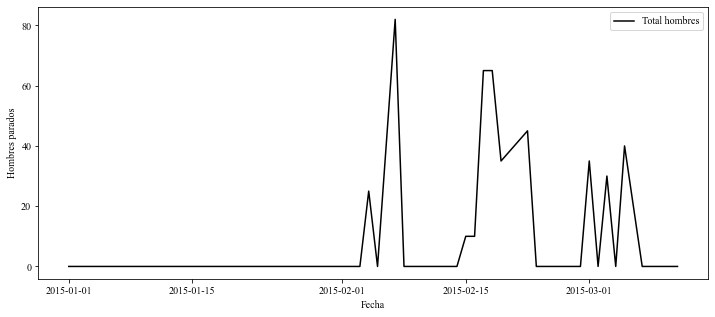

In [128]:
# Los hombres parados fueron del área de costura y se dieron en fechas posteriores al 1 de febrero

paradas_fecha = data.groupby(['date', 'department'], as_index=False)['idle_men'].sum()
paradas_fecha = paradas_fecha.pivot(index=['date'], columns=['department'], values='idle_men').reset_index()
paradas_fecha['total'] = paradas_fecha['Acabado'] + paradas_fecha['Costura']
print(paradas_fecha['Acabado'].sum())

plt.figure(figsize=(12, 5))
sns.lineplot(data=paradas_fecha, x='date', y='total', label='Total hombres', color='#000000')
plt.ylabel('Hombres parados')
plt.xlabel('Fecha')
plt.show()

In [138]:
# Asignar los valores del atributo quarter
data['quarter'] = data['quarter'].str.replace('Quarter','').astype('int')

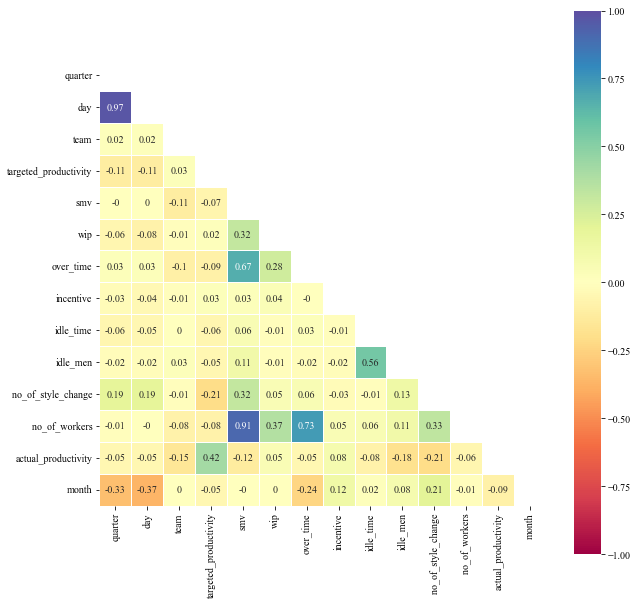

In [142]:
# Correlación entre los atributos
data1 = data.drop(columns=[
        'tiene_incentivo', 'trabajador_inactivo', 'tiempo_parado',
        'parada_produccion', 'problema_productividad', 'diferencia_productividad'])

corr = data1.corr()
corr = corr.round(2)
mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))]=True

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='Spectral', square=True, mask=mask, linecolor='white', linewidths=1)
plt.show()

In [145]:
data1.dtypes

date                     datetime64[ns]
quarter                           int32
department                       object
day                               int64
team                              int64
targeted_productivity           float64
smv                             float64
wip                             float64
over_time                         int64
incentive                         int64
idle_time                       float64
idle_men                          int64
no_of_style_change                int64
no_of_workers                   float64
actual_productivity             float64
month                             int64
dtype: object

In [147]:
data1 = pd.get_dummies(data1, columns=['department','team', 'quarter'])
data1 = data1.drop(columns=['date'])

In [157]:
data1.to_csv('data.csv', index=False)